# Run the following commands in terminal to install libraries
conda install -c conda-forge opencv<br>
conda install -c anaconda numpy<br>
conda install -c anaconda keras tensorflow<br>
conda install -c anaconda scipy<br>
pip install fastdtw <br>
pip install matplotlib<br>
pip install pillow

In [1]:
import os
import cv2
import numpy as np
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image
import keras.utils as image
from scipy.cluster.hierarchy import linkage, fcluster
from fastdtw import fastdtw
from scipy.spatial.distance import squareform, pdist
from glob import glob
from keras.utils import load_img, img_to_array
from scipy.cluster.hierarchy import dendrogram, cophenet
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt
import shutil

2023-10-20 15:27:49.572485: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
#clearing directory

import shutil
import os

def clear_directory(directory):
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print(f'Failed to delete {file_path}. Reason: {e}')
# Clear the frames directory
clear_directory(frames_dir)

# Clear the output directory
clear_directory(output_dir)

# Clear the merged directory
clear_directory('merged/')

In [2]:
video_path = 'squat.mp4'
frames_dir = 'frames'

In [3]:
os.makedirs(frames_dir, exist_ok=True)

cap = cv2.VideoCapture(video_path)
frame_count = 0
skip_frames = 3
while True:
    ret, frame = cap.read()
    if not ret:
        break
    if frame_count % skip_frames == 0:
        cv2.imwrite(os.path.join(frames_dir, f'frame{frame_count}.jpg'), frame)
    frame_count += 1

cap.release()
print(f"Extracted {frame_count//skip_frames} frames to {frames_dir}")


[ WARN:0@154.396] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@154.397] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'




Extracted 62 frames to frames


In [4]:
model = VGG16(include_top=False, weights='imagenet')

def extract_features(img_path):
    img = load_img(img_path, target_size=(224, 224))
    img_data = img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)

    features = model.predict(img_data)
    return features.flatten()

frame_files = sorted(glob(os.path.join(frames_dir, '*.jpg')))
frame_features = np.array([extract_features(f) for f in frame_files])


2023-10-20 15:31:00.079830: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


1/1 [==============================] - 0s 433ms/step


In [5]:
# Compute DTW distances between feature sequences
distances = pdist(frame_features, lambda x, y: fastdtw(x, y)[0])
distance_matrix = squareform(distances)

# Hierarchical clustering using the precomputed distance matrix
Z = linkage(distance_matrix, 'ward')

/var/folders/bz/g1nvx8713h99kgw9fnr0jc_00000gn/T/ipykernel_57297/190841859.py:6: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distance_matrix, 'ward')


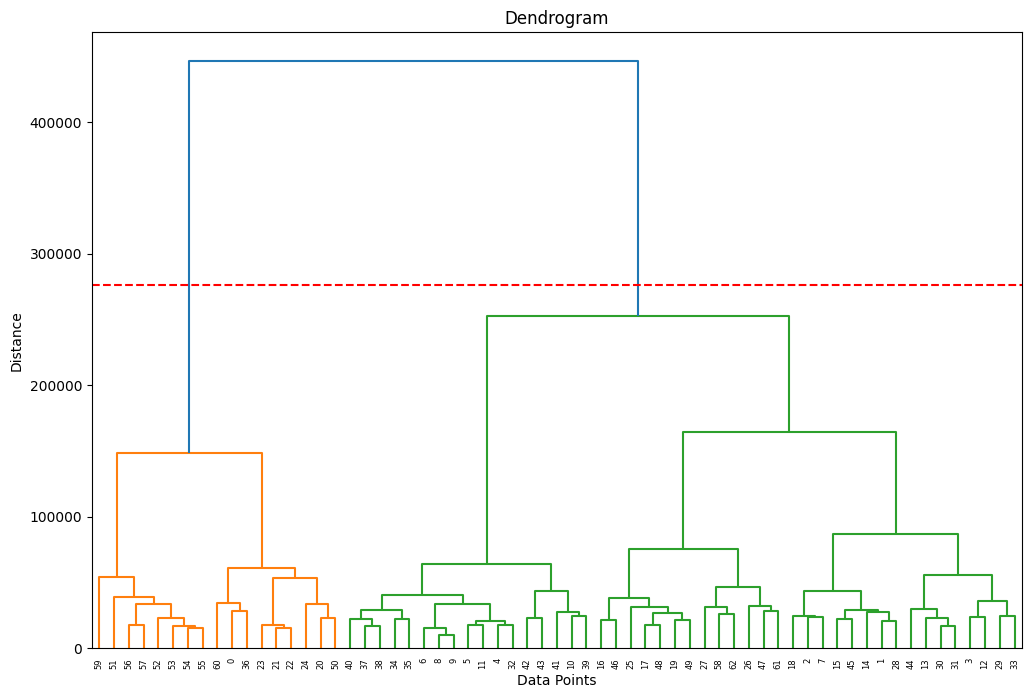

In [6]:
# Compute cophenetic correlation to measure how faithfully the dendrogram preserves pairwise distances between data
_, coph_dists = cophenet(Z, pdist(frame_features, lambda x, y: fastdtw(x, y)[0]))

# Plot dendrogram
plt.figure(figsize=(12, 8))
dendrogram(Z)
plt.title('Dendrogram')
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.axhline(y=coph_dists.mean(), color='r', linestyle='--')
plt.show()


Explanation
Dendrogram: We're plotting a dendrogram, which is a tree-like diagram showing the arrangement of the clusters. Each merge of clusters is represented by a horizontal line, and the height of these lines shows the distance between the merged clusters.

Cophenetic Correlation Coefficient: We calculate this to measure how well the clustering preserves the pairwise distances between samples. The average distance serves as a threshold in the dendrogram to interpret the number of clusters.

Horizontal Line: We draw a horizontal line on the dendrogram at the average cophenetic distance, and the number of intersections with the dendrogram gives an estimation of the optimal number of clusters.

Choosing Clusters: The number of vertical lines the horizontal line intersects in the dendrogram can help decide the number of clusters.

In [8]:
optimal_clusters = 5   # Choose this based on your data and requirements
clusters = fcluster(Z, t=optimal_clusters, criterion='maxclust')


In [9]:
from PIL import Image, ImageDraw, ImageFont

output_dir = 'output'
os.makedirs(output_dir, exist_ok=True)

representative_frames = []

frame_sequence = 1  # Initialize the sequence number

font_path = "/System/Library/Fonts/Supplemental/Arial.ttf"  # Specify the path to Arial font

for i in range(1, optimal_clusters + 1):
    indices = np.where(clusters == i)[0]
    intra_cluster_dists = distance_matrix[indices][:, indices]
    representative_frame_index = indices[np.argmin(np.sum(intra_cluster_dists, axis=0))]
    representative_frame_file = frame_files[representative_frame_index]

    # Open the frame using PIL and overlay the sequence number
    img = Image.open(representative_frame_file)
    draw = ImageDraw.Draw(img)
    
    # Use the specified font path and adjust the font size and position according to your needs
    font = ImageFont.truetype(font_path, 50)
    draw.text((10, 10), str(frame_sequence), font=font, fill=(0, 0, 255))  # Set fill color to blue
    
    # Save the numbered frame
    img.save(os.path.join(output_dir, f'frame_{frame_sequence}.jpg'))
    
    representative_frames.append(os.path.join(output_dir, f'frame_{frame_sequence}.jpg'))

    frame_sequence += 1  # Increment the sequence number

print(representative_frames)
print("Numbered frames saved to:", output_dir)


['output/frame_1.jpg', 'output/frame_2.jpg', 'output/frame_3.jpg', 'output/frame_4.jpg', 'output/frame_5.jpg']
Numbered frames saved to: output


In [10]:
from PIL import Image
import os

# Input folder containing the extracted frames
frames_folder = 'output/'

# Output folder where contact sheets will be saved
output_folder = 'merged/'

# Number of columns for each contact sheet
num_columns = 5

# Maximum supported image dimension
max_dimension = 65500

# List all image files in the frames folder
frame_files = [f for f in os.listdir(frames_folder) if f.endswith('.jpg')]

# Sort the frame files to ensure the correct order
frame_files.sort()

# Define a function to process a batch of images and return a single contact sheet
def process_image_batch(image_batch, output_path):
    # Get the dimensions of the first image in the batch
    width, height = image_batch[0].size
    
    # Calculate the maximum number of rows and columns that fit within the maximum dimension
    max_columns = min(num_columns, max_dimension // width)
    max_rows = (len(image_batch) + max_columns - 1) // max_columns
    
    # Calculate the new width and height for the contact sheet
    new_width = width * max_columns
    new_height = height * max_rows

    contact_sheet = Image.new('RGB', (new_width, new_height))

    x_offset = 0
    y_offset = 0

    for image in image_batch:
        contact_sheet.paste(image, (x_offset, y_offset))
        x_offset += width

        if x_offset >= new_width:
            x_offset = 0
            y_offset += height

    # Save the contact sheet with adjustable JPEG compression quality
    contact_sheet.save(output_path, format='JPEG', quality=95)

# Create the output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Process images in batches and save multiple contact sheets
batch_size = 50  # You can adjust this based on your system's file descriptor limit
contact_sheet_count = 0

for i in range(0, len(frame_files), batch_size):
    batch_files = frame_files[i:i + batch_size]
    batch_images = [Image.open(os.path.join(frames_folder, frame)) for frame in batch_files]
    
    # Determine the output path for the contact sheet
    contact_sheet_path = os.path.join(output_folder, f'contact_sheet_{contact_sheet_count}.jpg')
    
    process_image_batch(batch_images, contact_sheet_path)
    
    contact_sheet_count += 1

print(f"{contact_sheet_count} contact sheets saved in {output_folder}")


1 contact sheets saved in merged/


In [ ]:
###modification of code: clear directory

In [ ]:
# import matplotlib.font_manager
# fonts = set([f.name for f in matplotlib.font_manager.fontManager.ttflist])
# 'Arial' in fonts


In [ ]:
# from PIL import Image, ImageDraw, ImageFont

# output_dir = 'output'
# os.makedirs(output_dir, exist_ok=True)

# representative_frames = []

# frame_sequence = 1  # Initialize the sequence number

# font_path = "/System/Library/Fonts/Supplemental/Arial.ttf"  # Specify the path to Arial font

# for i in range(1, optimal_clusters + 1):
#     indices = np.where(clusters == i)[0]
#     intra_cluster_dists = distance_matrix[indices][:, indices]
#     representative_frame_index = indices[np.argmin(np.sum(intra_cluster_dists, axis=0))]
#     representative_frame_file = frame_files[representative_frame_index]

#     # Open the frame using PIL and overlay the sequence number
#     img = Image.open(representative_frame_file)
#     draw = ImageDraw.Draw(img)
    
#     # Use the specified font path and adjust the font size and position according to your needs
#     font = ImageFont.truetype(font_path, 50)
#     draw.text((10, 10), str(frame_sequence), font=font, fill=(255, 255, 255))
    
#     # Save the numbered frame
#     img.save(os.path.join(output_dir, f'frame_{frame_sequence}.jpg'))
    
#     representative_frames.append(os.path.join(output_dir, f'frame_{frame_sequence}.jpg'))

#     frame_sequence += 1  # Increment the sequence number

# print(representative_frames)
# print("Numbered frames saved to:", output_dir)
